# Task 2.5 from Sutton-Barto

Implementation based on code given in HW1. Modified version of ten-armed bandit is contained in ten_arm_modified_env. All the q* are initialized with the same randof value from [0, 1] after that during each iteration N(0, 0.01) is added to each q*.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import main_agent
import ten_arm_env
import ten_arm_modified_env
import test_env
from tqdm import tqdm
import time

In [2]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties.clear()
        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

In [3]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action])/self.arm_count[self.last_action]
        current_action = argmax(self.q_values)    
        self.last_action = current_action        
        return current_action

In [4]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action])/self.arm_count[self.last_action]
        
        new_epsilon = np.random.rand()
        if new_epsilon < self.epsilon:
            current_action = np.random.randint(self.num_actions)
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action

In [5]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action])*self.step_size
        
        new_epsilon = np.random.rand()
        if new_epsilon < self.epsilon:
            current_action = np.random.randint(self.num_actions)
        else:
            current_action = argmax(self.q_values)    
        
        self.last_action = current_action
        
        return current_action

# Modified ten-armed bandit

In [9]:
num_runs = 200
num_steps = 1000

agents = {"Greedy": (GreedyAgent, {"num_actions": 10}),
          "Greedy Optimist": (GreedyAgent, {"num_actions": 10, "initial_value": 5}),
          "Epsilon Greedy 0.1": (EpsilonGreedyAgent, {"num_actions": 10, "epsilon": 0.1}),
          "Epsilon Greedy 0.01": (EpsilonGreedyAgent, {"num_actions": 10, "epsilon": 0.01}),
          "Epsilon Greedy 0.1 const step": (EpsilonGreedyAgentConstantStepsize, 
                                            {"num_actions": 10, "epsilon": 0.1, "step_size": 0.1})}


env = ten_arm_modified_env.EnvironmentModified
env_info = {}
averages_results = {}
best_actions_results = {}

for key in agents:
    all_averages = []
    best_actions = []
    for i in tqdm(range(num_runs)):
        rl_glue = RLGlue(env, agents[key][0])
        rl_glue.rl_init(agents[key][1], env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        best_arms_choosen = []
        for i in range(num_steps):
            reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                     # the reward, and action taken.
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            best_arms_choosen.append(1 if action == np.argmax(rl_glue.environment.arms) else 0)
        best_actions.append(best_arms_choosen)    
        all_averages.append(averages)
    averages_results[key] = np.mean(all_averages, axis=0)
    best_actions_results[key] = np.mean(best_actions, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 13.15it/s]


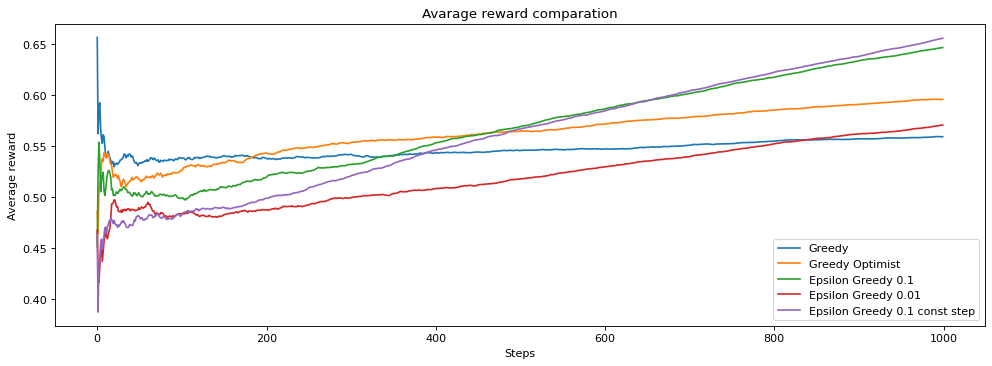

In [10]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Avarage reward comparation")
plt.xlabel("Steps")
plt.ylabel("Average reward")
for key in averages_results:
    plt.plot(averages_results[key])
plt.legend(averages_results.keys())
plt.show()

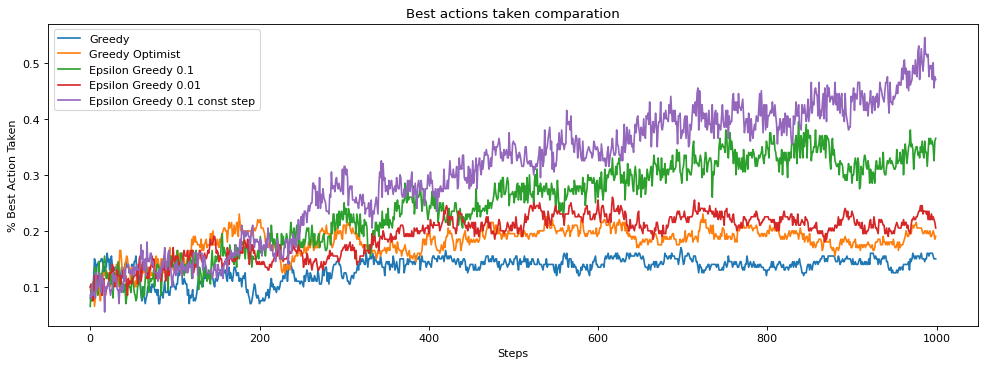

In [11]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Best actions taken comparation")
plt.xlabel("Steps")
plt.ylabel("% Best Action Taken")
for key in best_actions_results:
    plt.plot(best_actions_results[key])
plt.legend(best_actions_results.keys())
plt.show()